<a href="https://colab.research.google.com/github/AsmaaIbrahiim/Face-Mask-Detection/blob/model_1/Face_Mask_Detection%7C_Transfer_learning_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

University of Science and Technology, Zewail City <br>
Communications and Information Engineering Program <br>
CIE 555 - Deep Learning and Neural Networks <br>
Course Project - **Face Mask Detection**

# **Imports**

In [79]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image_dataset_from_directory
import matplotlib.pyplot as plt
# =========================================== #
import keras.applications
from keras.models import Model
from keras.layers import Dense, Flatten,Dropout
import tensorflow as tf

# **Dataset Import**

In [83]:
# Import PyDrive and associated libraries.
# This only needs to be done once per notebook.
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client.
# This only needs to be done once per notebook.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

# Download a file based on its file ID.
file_id = '1UXAbqllbeh14XslYxAuTOfd3hsvbmp0G'
downloaded = drive.CreateFile({'id': file_id})
downloaded.GetContentFile('archive.zip')

In [84]:
!mkdir /content/dataset
!unzip -q /content/archive.zip -d /content/dataset 

mkdir: cannot create directory ‘/content/dataset’: File exists
replace /content/dataset/Face Mask Dataset/Test/WithMask/1163.png? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace /content/dataset/Face Mask Dataset/Test/WithMask/1174.png? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
n


# **Dataset Visualization**

# **Loading data into generators + Helper Functions**

In [41]:
# General Parameters
train_dir='/content/dataset/Face Mask Dataset/Train'
val_dir='/content/dataset/Face Mask Dataset/Validation'
test_dir='/content/dataset/Face Mask Dataset/Test'
HEIGHT = 128
WIDTH = 128
BATCH_SIZE = 500

In [42]:
def get_generators(preprocessing_object = tf.keras.applications.vgg19.preprocess_input):
  #preprocessing_function = preprocessing_object,
  train_generator=ImageDataGenerator(
                                    rescale=1/255,
                                    rotation_range = 40,
                                    height_shift_range=(-4,4),
                                    width_shift_range = (-4,4),
                                    brightness_range = (0.3,1.7))
  val_generator=ImageDataGenerator(
                                    rescale=1/255,
                                    rotation_range = 40,
                                    height_shift_range=(-4,4),
                                    width_shift_range = (-4,4),
                                    brightness_range = (0.3,1.7))
  test_generator= ImageDataGenerator(preprocessing_function = preprocessing_object)

  ### Generators; train, val and test
  train_data_generator=train_generator.flow_from_directory(train_dir,
                                              target_size=(HEIGHT,WIDTH),
                                              batch_size = BATCH_SIZE,
                                              shuffle = True,
                                              class_mode='categorical',
                                              color_mode='rgb')

  val_data_generator=val_generator.flow_from_directory(val_dir,
                                              target_size=(HEIGHT,WIDTH),
                                              batch_size = BATCH_SIZE,
                                              shuffle = True,
                                              class_mode='categorical',
                                              color_mode='rgb')
  test_data_generator=test_generator.flow_from_directory(test_dir,
                                              target_size=(HEIGHT,WIDTH),
                                              batch_size = BATCH_SIZE,
                                              shuffle = False,
                                              class_mode='categorical',
                                              color_mode='rgb')
  return train_data_generator, val_data_generator, test_data_generator

In [73]:
def plot_history(history):
  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']

  loss = history.history['loss']
  val_loss = history.history['val_loss']

  plt.figure(figsize=(8, 8))
  plt.subplot(2, 1, 1)
  plt.plot(acc, label='Training Accuracy')
  plt.plot(val_acc, label='Validation Accuracy')
  plt.legend(loc='lower right')
  plt.ylabel('Accuracy')
  #plt.ylim([min(plt.ylim()),1])
  plt.title('Training and Validation Accuracy')

  plt.subplot(2, 1, 2)
  plt.plot(loss, label='Training Loss')
  plt.plot(val_loss, label='Validation Loss')
  plt.legend(loc='upper right')
  plt.ylabel('Categorical Cross Entropy')
  #plt.ylim([0,1.0])
  plt.title('Training and Validation Loss')
  plt.xlabel('epoch')
  plt.show()

# **Models**

*As one of the most popular and effect transfer learning model in use of images, VGG16 model is tried on our dataset.*

In [43]:
# Generators
train_data_generator, val_data_generator, test_data_generator = get_generators(tf.keras.applications.vgg19.preprocess_input)

Found 10000 images belonging to 2 classes.
Found 800 images belonging to 2 classes.
Found 992 images belonging to 2 classes.


In [62]:
images, labels = next(train_data_generator)

print(images.shape)
print(labels.shape)

(500, 128, 128, 3)
(500, 2)


## **First Model**: VGG16

The first trial is just using the pre-trained model with minimum contribution

In [49]:
from keras.applications.vgg16 import VGG16

# Load model without classification head
base_model = VGG16(include_top = False,
                   weights = 'imagenet',
                   input_shape = (HEIGHT, WIDTH, 3))

# Mark loaded layers as not trainable
for layer in base_model.layers:
  layer.trainable = False

# Add new classifier layers
x = Flatten()(base_model.layers[-1].output)
x = Dense(64, activation='relu')(x)
output = Dense(2, activation='sigmoid')(x)

# Define new model
model = Model(inputs = base_model.inputs, outputs = output)

# Print summary
model.summary()

# Compile
base_learning_rate = 0.0001
model.compile(optimizer = tf.keras.optimizers.SGD(learning_rate = base_learning_rate),
            loss = 'binary_crossentropy',
            metrics = ['accuracy'])

Model: "model_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         [(None, 128, 128, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 128, 128, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 128, 128, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 64, 64, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 64, 64, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 64, 64, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 32, 32, 128)       0   

**Let's train the model!!**

In [50]:
# I can choose small number of epochs for initial investigation for the model perfomance
INITIAL_EPOCHS = 5

history = model.fit(train_data_generator,
                    validation_data = val_data_generator,
                    epochs = INITIAL_EPOCHS,
                    steps_per_epoch=10000//BATCH_SIZE,
                    validation_steps=800//BATCH_SIZE,
                    batch_size = BATCH_SIZE)

Epoch 1/5
20/20 [==============================] - 54s 3s/step - loss: 0.7298 - accuracy: 0.4985 - val_loss: 0.7279 - val_accuracy: 0.4820
Epoch 2/5
20/20 [==============================] - 52s 3s/step - loss: 0.7132 - accuracy: 0.5080 - val_loss: 0.7172 - val_accuracy: 0.4880
Epoch 3/5
20/20 [==============================] - 52s 3s/step - loss: 0.7048 - accuracy: 0.5256 - val_loss: 0.7070 - val_accuracy: 0.5060
Epoch 4/5
20/20 [==============================] - 52s 3s/step - loss: 0.6987 - accuracy: 0.5312 - val_loss: 0.7064 - val_accuracy: 0.5080
Epoch 5/5
20/20 [==============================] - 52s 3s/step - loss: 0.6915 - accuracy: 0.5603 - val_loss: 0.6938 - val_accuracy: 0.5320


The VGG16 model seems promising but relatively slow, hence we're going to raise the learning rate to notice its effect.

In [69]:
# Add new classifier layers
x = Flatten()(base_model.layers[-1].output)
x = Dense(64, activation='relu')(x)
output = Dense(2, activation='sigmoid')(x)

# Define new model
model = Model(inputs = base_model.inputs, outputs = output)

# Compile
base_learning_rate = 0.01
model.compile(optimizer = tf.keras.optimizers.SGD(learning_rate = base_learning_rate),
            loss = 'binary_crossentropy',
            metrics = ['accuracy'])

history = model.fit(train_data_generator,
                    validation_data = val_data_generator,
                    epochs = INITIAL_EPOCHS,
                    steps_per_epoch=10000//BATCH_SIZE,
                    validation_steps=800//BATCH_SIZE,
                    batch_size = BATCH_SIZE)

Epoch 1/5
20/20 [==============================] - 176s 3s/step - loss: 0.6527 - accuracy: 0.6204 - val_loss: 0.5984 - val_accuracy: 0.6140
Epoch 2/5
20/20 [==============================] - 53s 3s/step - loss: 0.5964 - accuracy: 0.6127 - val_loss: 0.5234 - val_accuracy: 0.7000
Epoch 3/5
20/20 [==============================] - 53s 3s/step - loss: 0.4178 - accuracy: 0.8179 - val_loss: 0.3747 - val_accuracy: 0.8080
Epoch 4/5
20/20 [==============================] - 53s 3s/step - loss: 0.3975 - accuracy: 0.8151 - val_loss: 0.3132 - val_accuracy: 0.8760
Epoch 5/5
20/20 [==============================] - 53s 3s/step - loss: 0.3097 - accuracy: 0.8906 - val_loss: 0.2651 - val_accuracy: 0.9080


Yes, that's right! The model behaves better with higher learning rate. Let's try the same model with different optimizer (Adam).

In [70]:
# Add new classifier layers
x = Flatten()(base_model.layers[-1].output)
x = Dense(64, activation='relu')(x)
output = Dense(2, activation='sigmoid')(x)

# Define new model
model = Model(inputs = base_model.inputs, outputs = output)

# Compile
base_learning_rate = 0.01
model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = base_learning_rate),
            loss = 'binary_crossentropy',
            metrics = ['accuracy'])

history = model.fit(train_data_generator,
                    validation_data = val_data_generator,
                    epochs = INITIAL_EPOCHS,
                    steps_per_epoch=10000//BATCH_SIZE,
                    validation_steps=800//BATCH_SIZE,
                    batch_size = BATCH_SIZE)

Epoch 1/5
20/20 [==============================] - 54s 3s/step - loss: 3.0916 - accuracy: 0.6469 - val_loss: 0.2684 - val_accuracy: 0.8980
Epoch 2/5
20/20 [==============================] - 52s 3s/step - loss: 0.1931 - accuracy: 0.9268 - val_loss: 0.1124 - val_accuracy: 0.9580
Epoch 3/5
20/20 [==============================] - 53s 3s/step - loss: 0.1097 - accuracy: 0.9558 - val_loss: 0.0932 - val_accuracy: 0.9700
Epoch 4/5
20/20 [==============================] - 54s 3s/step - loss: 0.0802 - accuracy: 0.9710 - val_loss: 0.0890 - val_accuracy: 0.9620
Epoch 5/5
20/20 [==============================] - 53s 3s/step - loss: 0.0705 - accuracy: 0.9721 - val_loss: 0.0756 - val_accuracy: 0.9660


Adam Optimizer has already boosted the model behavior. The next step is to include more layers for robustness in addition to dropout layers to somehow avoid overfitting.

In [72]:
# Add new classifier layers
x = Flatten()(base_model.layers[-1].output)
x = Dense(256, activation='relu')(x)
x = Dropout(0.3)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.3)(x)
x = Dense(64, activation='relu')(x)
output = Dense(2, activation='sigmoid')(x)

# Define new model
model = Model(inputs = base_model.inputs, outputs = output)

# Compile
base_learning_rate = 0.01
model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = base_learning_rate),
            loss = 'binary_crossentropy',
            metrics = ['accuracy'])

history = model.fit(train_data_generator,
                    validation_data = val_data_generator,
                    epochs = 15,
                    steps_per_epoch=10000//BATCH_SIZE,
                    validation_steps=800//BATCH_SIZE,
                    batch_size = BATCH_SIZE)

Epoch 1/15
20/20 [==============================] - 55s 3s/step - loss: 2.2918 - accuracy: 0.7084 - val_loss: 0.1535 - val_accuracy: 0.9500
Epoch 2/15
20/20 [==============================] - 52s 3s/step - loss: 0.1444 - accuracy: 0.9480 - val_loss: 0.0993 - val_accuracy: 0.9620
Epoch 3/15
20/20 [==============================] - 53s 3s/step - loss: 0.1053 - accuracy: 0.9610 - val_loss: 0.0721 - val_accuracy: 0.9780
Epoch 4/15
20/20 [==============================] - 52s 3s/step - loss: 0.0868 - accuracy: 0.9678 - val_loss: 0.0686 - val_accuracy: 0.9760
Epoch 5/15
20/20 [==============================] - 52s 3s/step - loss: 0.0739 - accuracy: 0.9728 - val_loss: 0.0501 - val_accuracy: 0.9800
Epoch 6/15
20/20 [==============================] - 52s 3s/step - loss: 0.0694 - accuracy: 0.9744 - val_loss: 0.0790 - val_accuracy: 0.9780
Epoch 7/15
20/20 [==============================] - 52s 3s/step - loss: 0.0707 - accuracy: 0.9723 - val_loss: 0.0314 - val_accuracy: 0.9900
Epoch 8/15
20/20 [==

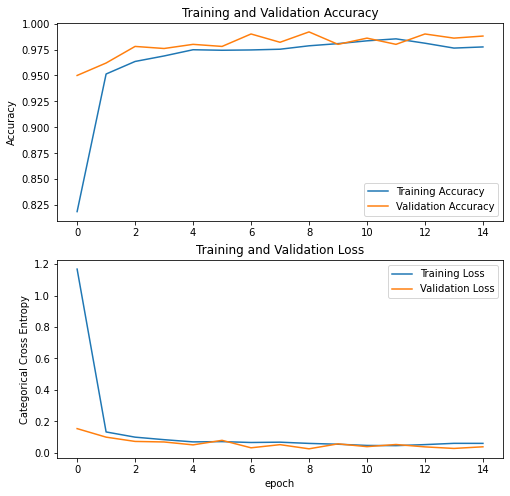

In [74]:
plot_history(history)

In [76]:
# Evaluation on test data !
model.metrics_names 
model.evaluate(test_data_generator, batch_size=BATCH_SIZE, steps=20)

20/20 [==============================] - 17s 875ms/step - loss: 1.2286 - accuracy: 0.9849


[1.2286109924316406, 0.9848790168762207]

**Great! We acheived the required performance with VGG16 model**

In [82]:
# Save the model!
model.save('face_mask_detection_vgg16')

INFO:tensorflow:Assets written to: face_mask_detection_vgg16/assets
